In [103]:
from polylabel import polylabel
import numpy as np
import xarray as xr
import netCDF4 as netcdf
import matplotlib.pyplot as plt
from helpers.rotation import RotateFromTo
from helpers.descriptors import centre_of_gravity
from helpers.descriptors import Section
from helpers.utils import reorder_MST
import os
import open3d as o3d
from tqdm import tqdm
import mistree as mist
from yaml import load
from yaml.loader import Loader
import networkx as nx
import itertools

In [5]:
caveName = "17_Hoelloch"
scan = 2

root = f"../../real_data/{caveName}"

PROCESSING_FILEPATH = os.path.join(root, "params.yaml")
p = load(open(PROCESSING_FILEPATH), Loader)

scanName = p['paths']['scanNames'][scan]
shift = p["alignment"]["globalShift"]

dir_fp = os.path.normpath(os.path.join(root, "process/sections_as_polylines/"))

sections_fp = [elem for elem in os.listdir(dir_fp) if scanName in elem and "unordered" not in elem]

fp = os.path.normpath(os.path.join(root, f"output/{scanName}", f"{scanName}_georef_subsampled.ply"))
# read the data
pcd = o3d.io.read_point_cloud(fp)

In [37]:
n = np.array([0, 1, 0]) # in the rotated  x,y,z plane coordinates, normal vector.

origins = []
node_indices = []
branch_indices = []
cog_origins = []
poles_origins = []

for section_fp in tqdm(sections_fp, total = len(sections_fp)):
    section = netcdf.Dataset(os.path.join(dir_fp, section_fp))
    coords = section.variables["__xarray_dataarray_variable__"]
    xz = coords[:]
    xz = reorder_MST(xz)
    xz_pole, dist = polylabel([xz.tolist()], with_distance=True, precision= 1e-1)
    cog = centre_of_gravity(xz, is3d=False)
    centroid = np.mean(xz, axis = 0)
    
    # now we move the pole of inacessibility in real coordinates. 
    vec = coords.normal
    orig = coords.position

    xz_pole_3d = np.array([xz_pole[0], 0 , xz_pole[1]])
    xz_cog_3d = np.array([cog[0], 0 , cog[1]])

    # calculate the rotation matrix needed to transform the normal vector to real coordinates
    RotationMatrix = RotateFromTo(n, vec)


    # transform the pole of inaccessibility vector to real coordinates. 
    xyz_pole = RotationMatrix @ xz_pole_3d
    xyz_cog = RotationMatrix @ xz_cog_3d
    pole_orig = orig +xyz_pole
    cog_orig = orig + xyz_cog

    origins.append(orig)
    node_indices.append(coords.node_index)
    branch_indices.append(coords.branch_index)
    cog_origins.append(cog_orig)
    poles_origins.append(pole_orig)

100%|████████████████████████████████████████████████████████████████████████████████| 535/535 [04:03<00:00,  2.19it/s]


In [6]:
centreline = np.loadtxt(f"../../real_data/17_Hoelloch/process/centrelines/{scanName}_centreline3d.txt")

In [7]:
origins = np.array(origins)
cog_origins = np.array(cog_origins)

points = np.asarray(pcd.points)

NameError: name 'origins' is not defined

In [73]:
mst = mist.GetMST(x=centreline[:, 2], y=centreline[:, 3], z=centreline[:, 4])
degree, edge_length, branch_length, branch_shape, edge_index, branch_index = mst.get_stats(include_index=True, k_neighbours= 15)

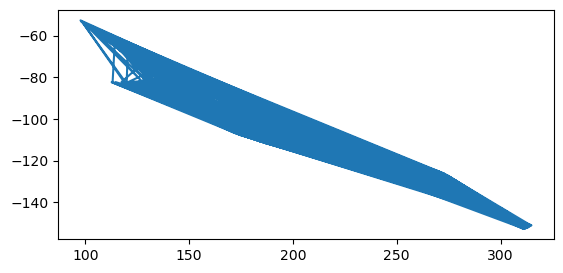

In [137]:
fig, ax = plt.subplots()
branch = 0
isInBranch = centreline[:, 0] == branch 
order
ax.plot(centreline[isInBranch,2],centreline[isInBranch,3])
ax.set_aspect("equal")

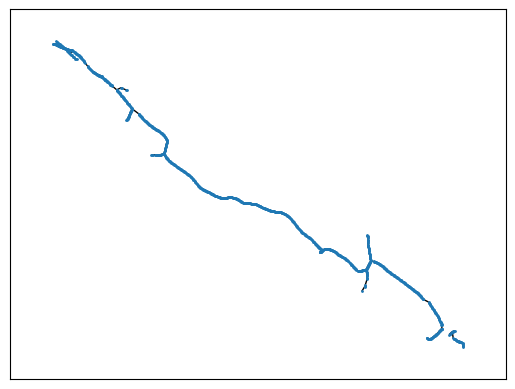

In [123]:
g = nx.graph.Graph(edge_index.T.tolist())

nx.draw_networkx(g, pos = centreline[:, [2, 3]], with_labels=False,node_size = 1)

DegreeView({19: 0, 20: 0, 22: 1, 30: 0, 32: 0, 66: 0, 67: 1, 68: 0, 75: 0, 89: 0, 90: 0, 94: 0, 109: 1, 110: 1, 116: 0, 130: 0, 131: 0, 132: 0, 142: 1, 148: 1, 157: 0, 163: 0, 173: 1, 174: 0, 177: 0, 178: 0, 189: 0, 190: 0, 195: 0, 196: 0, 199: 0, 207: 1, 213: 0, 214: 0, 215: 0, 216: 1, 217: 0, 222: 0, 224: 1, 233: 1, 234: 0, 240: 1, 241: 0, 252: 0, 253: 1, 256: 0, 263: 0, 264: 0, 265: 0, 268: 0, 270: 0, 271: 0, 273: 0, 283: 1, 286: 0, 290: 1, 291: 0, 292: 0, 293: 1, 303: 0, 315: 0, 316: 1, 317: 0, 325: 0, 332: 0, 333: 1, 337: 1, 355: 0, 365: 0, 381: 1, 382: 1, 389: 0, 390: 0, 404: 0, 405: 0, 413: 1, 414: 0, 419: 0, 420: 0})

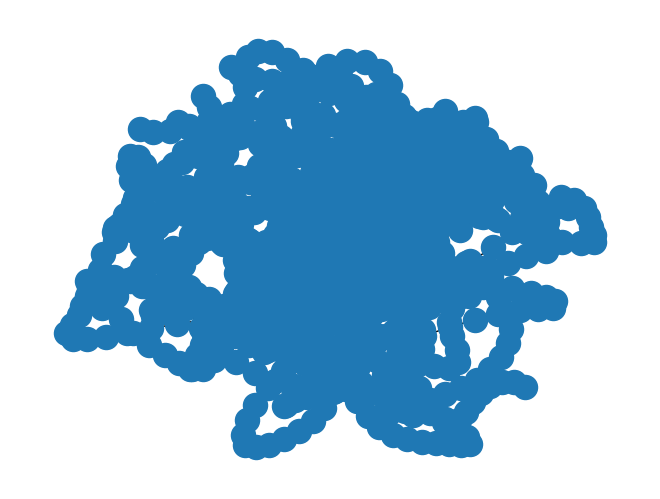

In [117]:
nx.draw(g, with_labels=False)

In [84]:
def reorder_MST(a, verbose = False):
    """
    reorders the array of points from an unordered output of a mesh / plane intersection.

    ----------
    
    arguments:

        points -> np.array: a numpy array with N target coordinates (N x 3 matrix)
        ind -> int : the index of the starting point
    ----------
    
    returns :

        ordered_points -> np.array : a numpy array containing the reordered data (N x 3 matrix)
    
    """
    
    mst = mist.GetMST(x=a[:, 0], y=a[:, 1])
    degree, edge_length, branch_length, branch_shape, edge_index, branch_index = mst.get_stats(include_index=True, k_neighbours= 10)
    
    full_graph = nx.graph.Graph(edge_index.T.tolist())
    
    # find the largest connected component. 
    cc0 = next(nx.connected_components(full_graph))
    cc0_graph = full_graph.subgraph(cc0)
    cc0_degrees = cc0_graph.degree() #Dict with Node ID, Degree
    cc0_nodes = cc0_graph.nodes()
    # find all degree 1 nodes
    deg1 = [key for key,value in dict(cc0_degrees).items() if value == 1]

    # find all paths connecting pairs of degree 1 nodes
    all_pairs = list(itertools.combinations(deg1, 2))

    path_lengths = np.array([len(next(nx.simple_paths.all_simple_paths(cc0_graph,*pair))) for pair in all_pairs])
    s, e = all_pairs[np.argmax(path_lengths)]
    longest_path_nodes = next(nx.simple_paths.all_simple_paths(cc0_graph,s, e))
    longest_path = cc0_graph.subgraph(longest_path_nodes)
    reordered  = a[longest_path_nodes]

    return reordered

[[162]
 [400]
 [450]
 [494]
 [715]
 [734]
 [744]
 [790]
 [811]
 [890]
 [923]
 [938]
 [939]
 [977]
 [994]]


In [74]:
nx.simple_paths.shortest_simple_paths(g, branch_index[0][0], branch_index[])

array([[  0,   2,   2, ..., 996, 997, 997],
       [119, 125, 168, ..., 995, 990, 995]], dtype=int32)

In [71]:

centreline[branch_index[1], 2]

array([246.60733032, 251.69206238, 267.7644043 , 154.02645874,
       141.54356384, 261.3132019 , 200.49882507, 307.54751587,
       282.10577393, 309.56832886, 258.07015991, 284.07562256,
       291.10031128, 213.0201416 ])

In [43]:
branch_mst = mist.GetMST(x=centreline[ordx, 2], y=centreline[ordx, 3], z=centreline[ordx, 4])
degree, edge_length, branch_length, branch_shape, edge_index, branch_index = branch_mst.get_stats(include_index=True, k_neighbours= 5)

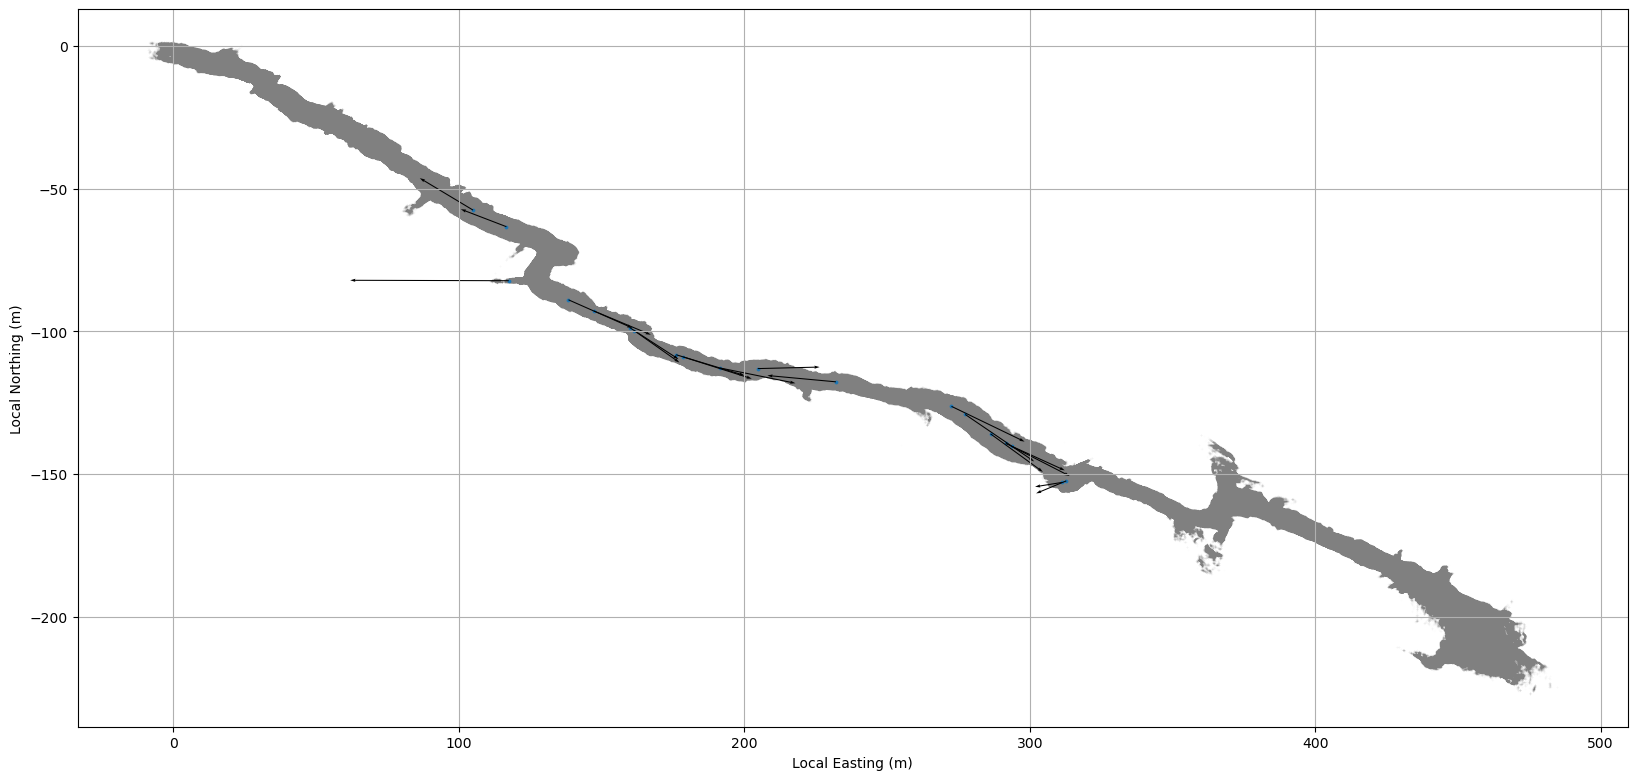

In [43]:
fig, ax1 = plt.subplots( figsize = (20, 10))

n = 2


ax1.scatter(centreline[ordx[::n], 2], centreline[ordx[::n],  3], s=3)
ax1.quiver(centreline[ordx[::n], 2], 
           centreline[ordx[::n], 3], 
           centreline[ordx[::n], 5], 
           centreline[ordx[::n], 6], 
           units = "dots", scale=0.02, width = 1.05)
ax1.scatter(points[:, 0], points[:, 1], s= 1, zorder = -100, color = "grey", alpha = 0.005)

ax1.set_aspect("equal")
ax1.grid()
ax1.set_ylabel("Local Northing (m)")
ax1.set_xlabel("Local Easting (m)")
plt.savefig(os.path.join(root, f"output/{scanName}", f"{scanName}_PlanView_LBC_centreline.png"), dpi = 300)
plt.show()

In [44]:
sections = []
sections_ok = []
for n, section_fp in tqdm(enumerate(sections_fp),  total = len(sections_fp)):
    section = netcdf.Dataset(os.path.join(dir_fp, section_fp))
    coords = section.variables["__xarray_dataarray_variable__"]
    xz = np.array(coords[:])
    xz = reorder_MST(xz)

    
    dists = np.linalg.norm(xz - np.roll(xz,1, axis = 0), axis = 1)
    if np.any(dists > 0.4):
        flag = "closure error"
    else: 
        flag = "ok"
        sections_ok.append(n)
        
    section = Section(xz,flag,n, from3d=False)
    section.compute_descriptors()
    section.fitEllipse()
    sections.append(section)

100%|████████████████████████████████████████████████████████████████████████████████| 535/535 [02:08<00:00,  4.16it/s]


In [46]:
print("all sections: ", len(sections), "  good sections:", len(sections_ok))

all sections:  535   good sections: 362


In [47]:
dHs = np.array([(n, elem.hydraulic_diameter) for n, elem in enumerate(sections) if elem.flag == "ok"])
idx = dHs[:, 0].astype(int)

areas = np.array([elem.area for elem in sections if elem.flag == "ok"])
solidities = np.array([elem.solidity for elem in sections if elem.flag == "ok"])

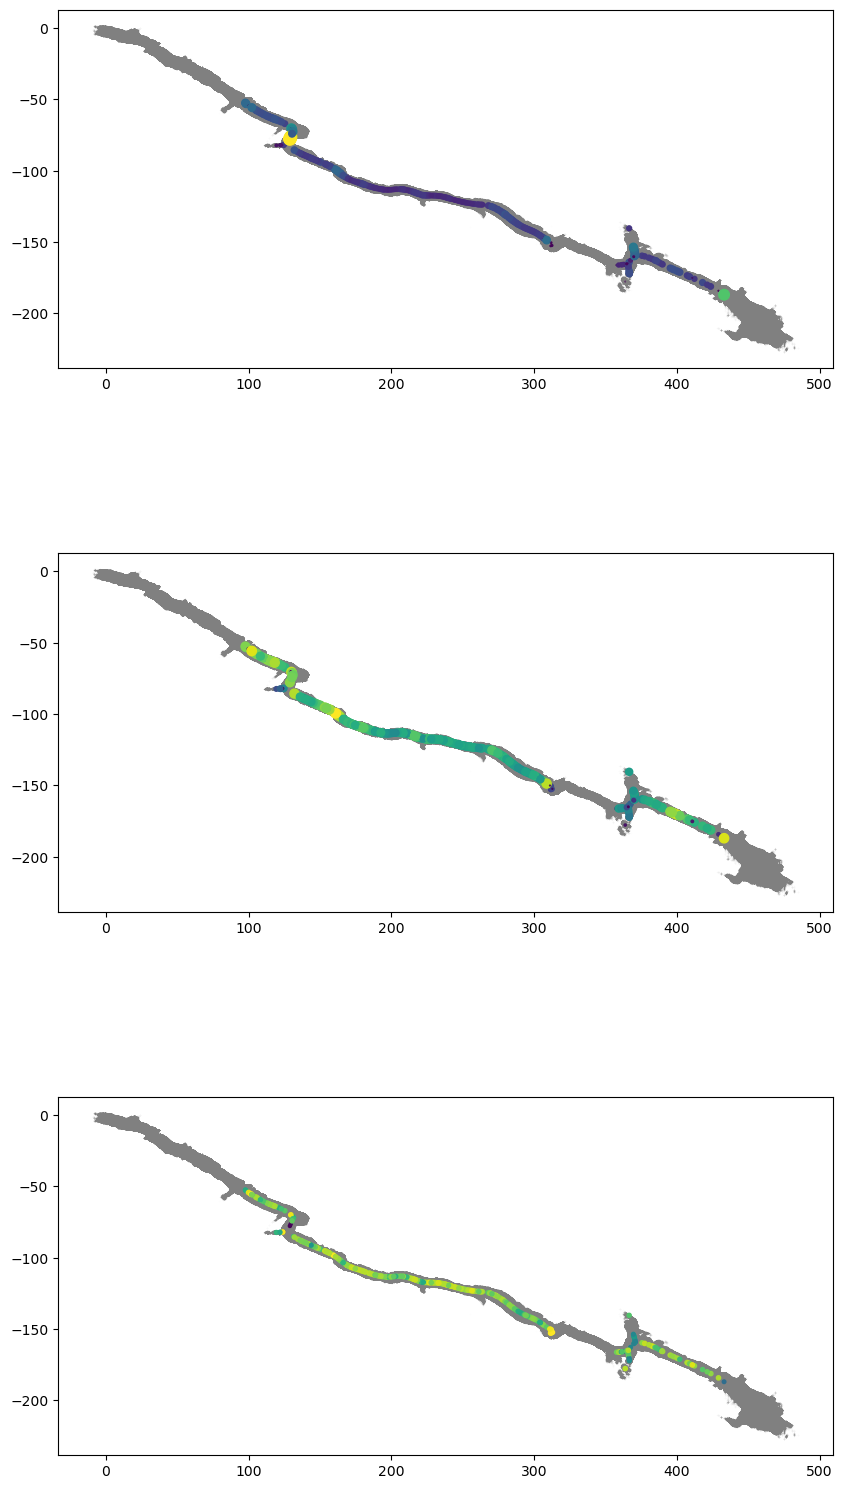

In [48]:
fig, (ax1, ax2, ax3)= plt.subplots(3, 1, figsize = (10, 20))

ax1.scatter(origins[idx, 0], origins[idx, 1], c= areas, s = areas)
ax1.scatter(points[:, 0], points[:, 1], s= 1, zorder = -100, color = "grey", alpha = 0.002)

ax1.set_aspect("equal")

ax2.scatter(origins[idx, 0], origins[idx, 1], c= dHs[:, 1],  s = dHs[:, 1]*10)
ax2.scatter(points[:, 0], points[:, 1], s= 1, zorder = -100, color = "grey", alpha = 0.002)

ax2.set_aspect("equal")

ax3.scatter(origins[idx, 0], origins[idx, 1], c= solidities,  s = solidities*10)
ax3.scatter(points[:, 0], points[:, 1], s= 1, zorder = -100, color = "grey", alpha = 0.002)

ax3.set_aspect("equal")

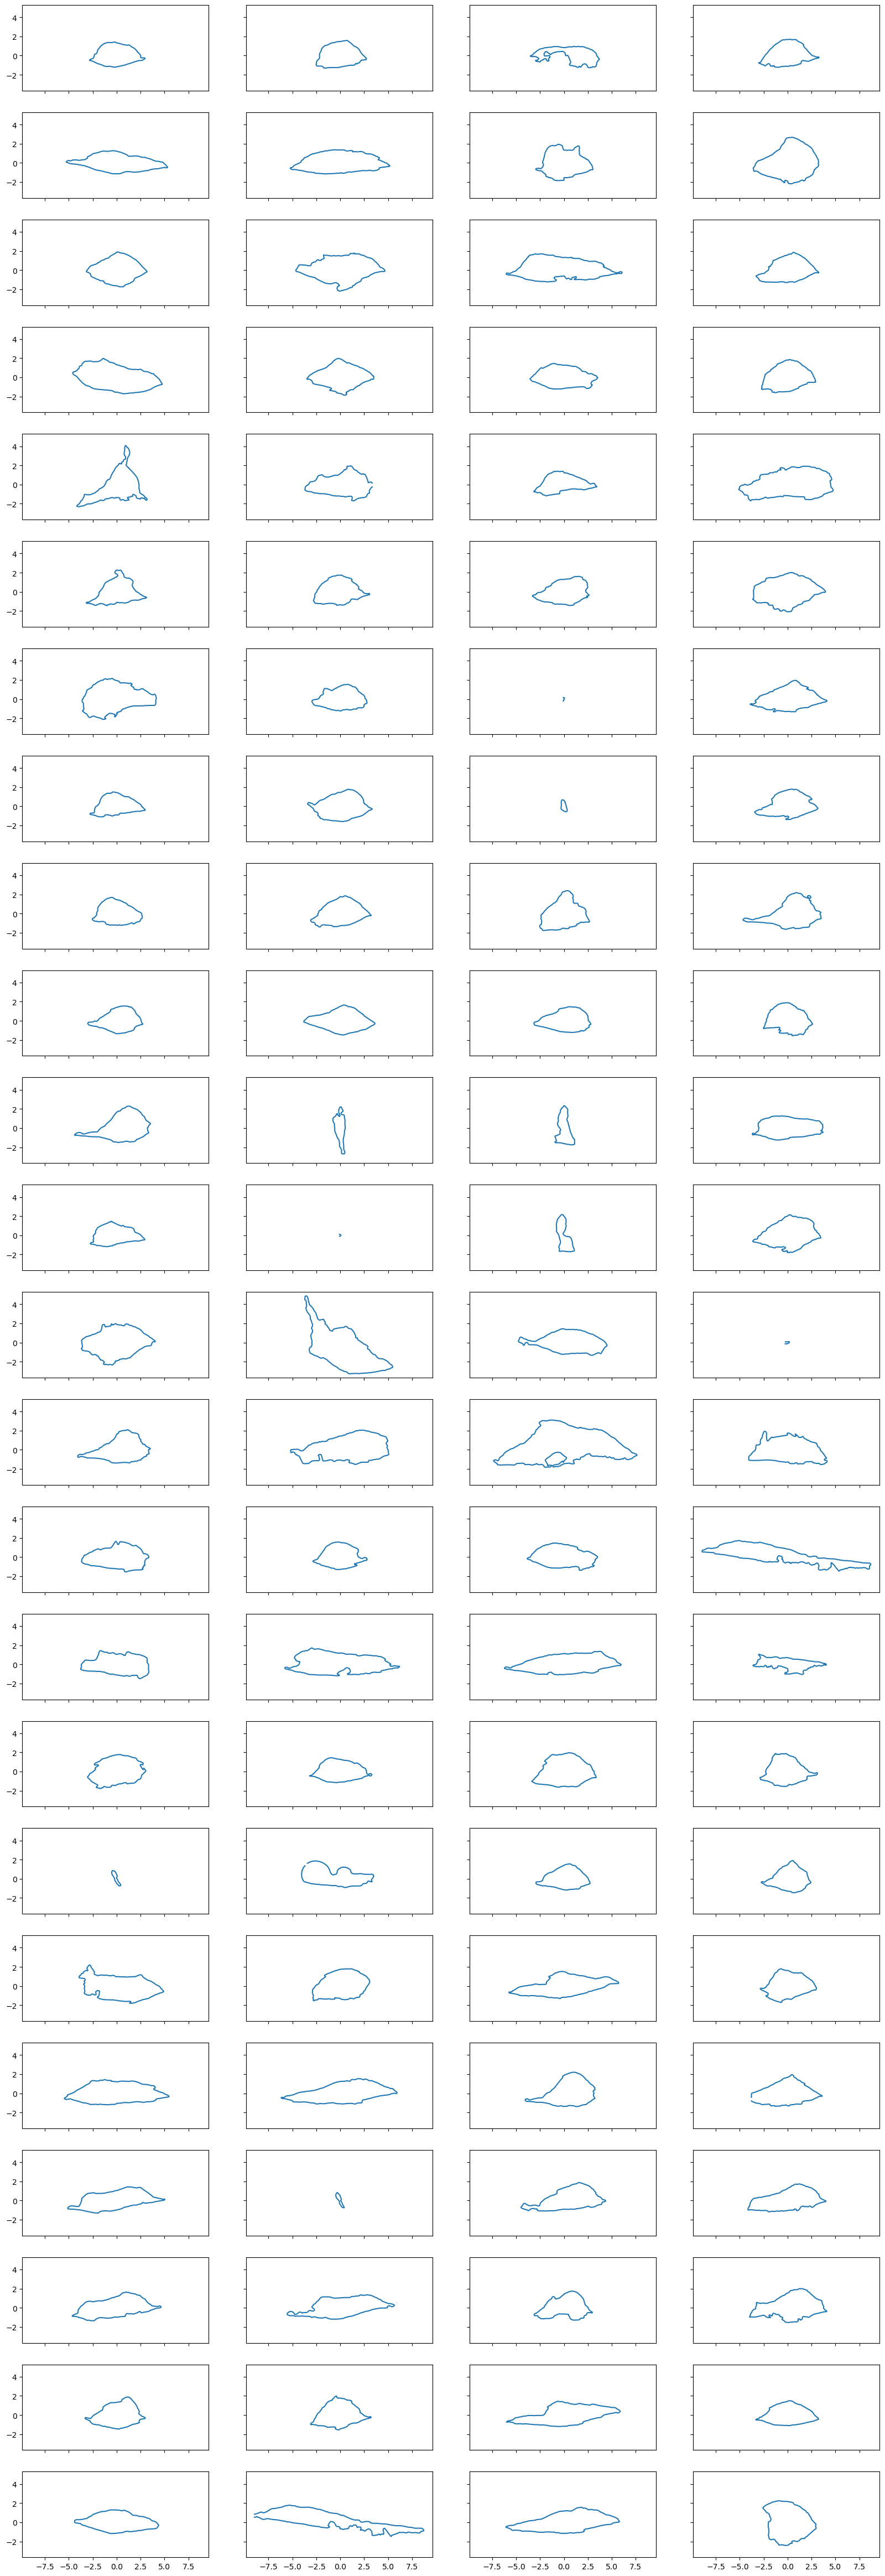

In [49]:
fig, axes = plt.subplots(24,4, figsize = (20, 60), sharex= True, sharey= True)

for c, ax in enumerate(axes.flatten()):
    ax.plot(sections[sections_ok[c]].points2d[:, 0], sections[sections_ok[c]].points2d[:, 1])
    ax.set_aspect("equal")

In [58]:
# calculate the stats on a single branch 
# branch 0
# calculate the curvilinear pos of a single branch. 





In [61]:
def find_section(sections, node_idx):
    res = None
    for sec in sections:
        if sec.curvilinear_pos == node_idx:
            res = sec
        
    return res

In [67]:
def get_branch_sections(branch_idx, branch_indices, node_indices, sections_ok):

    inbranch = branch_indices == 0
    branch_nodes = node_indices[inbranch]
    ok_branch_nodes = branch_nodes[np.isin(branch_nodes, sections_ok)]

    branch_sections = []

    for node in ok_branch_nodes:
        sec = find_section(sections, node)
        if sec is not None: 
            branch_sections.append(sec)
            
    return branch_sections, branch_nodes

In [70]:
branch0, branch0_idx = get_branch_sections(0, np.array(branch_indices), np.array(node_indices), sections_ok)

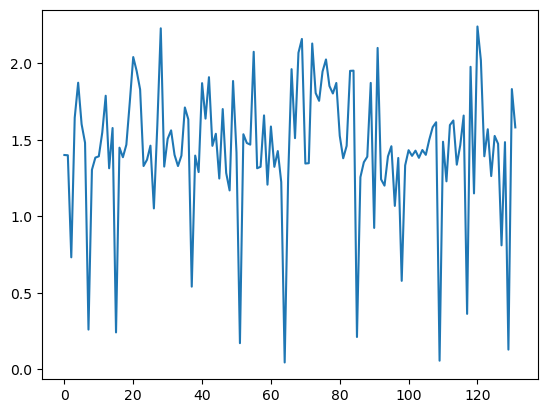

In [75]:
dHs = [sec.hydraulic_radius for sec in branch0]

fig, ax = plt.subplots()
ax.plot(dHs)

In [99]:


branch_centreline = centreline[np.isin(centreline[:, 1], branch0_idx)][:, [2,3,4]]

In [100]:
branch_mst =  mist.GetMST(x=branch_centreline[:, 0], y=branch_centreline[:, 1], z=branch_centreline[:, 2])
degree, edge_length, branch_length, branch_shape, edge_index, branch_index = branch_mst.get_stats(include_index=True, k_neighbours= 15)

In [102]:
degree

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.